<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


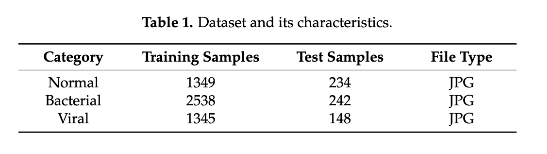

In [28]:
categories = ['PNEUMONIA', 'NORMAL']
img_size = 224 

def get_images(dir): 
    images_array = []
    height, width = [], []
    for category in categories: 
        path = os.path.join(dir, category)
        label = categories.index(category)
        for image in tqdm(os.listdir(path)): 
            try:
                img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                height.append(img_arr[0].shape)
                width.append(img_arr[1].shape)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # set image size 
                images_array.append([resized_arr, label])
            except Exception as e:
                print(e)
    print("width range: ", min(width),'-', max(width))
    print("height range: ", min(height),'-', max(height))
    return np.array(images_array)
train_dir = '/content/drive/MyDrive/Pneumonia/train'
train = get_images(train_dir)
test = get_images('/content/drive/MyDrive/Pneumonia/test')
val = get_images('/content/drive/MyDrive/Pneumonia/val')

100%|██████████| 1359/1359 [00:31<00:00, 42.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


width range:  (384,) - (2916,)
height range:  (384,) - (2916,)


100%|██████████| 234/234 [00:03<00:00, 60.61it/s]


width range:  (728,) - (2752,)
height range:  (728,) - (2752,)


100%|██████████| 8/8 [00:00<00:00, 67.89it/s]

width range:  (968,) - (1776,)
height range:  (968,) - (1776,)


## Exploratory analysis

###charts
- pneumonia vs normal 
- pneumonia type (bacteria vs virus) pie chart

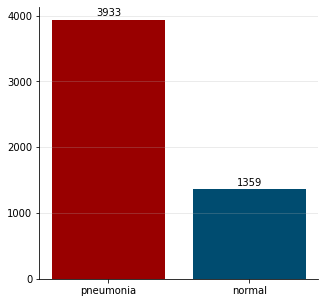

In [4]:
#@title
#pneumonia: label (0) & normal : label (1)
total_p = len(train[:, [1]]) - sum(train[:, [1]])
total_n = sum(train[:, [1]])
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [total_p[0], total_n[0]], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)

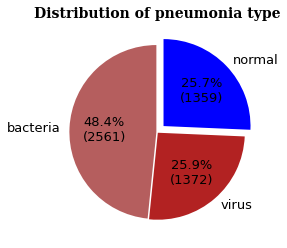

In [26]:
#@title 
# train_dir = "/content/drive/MyDrive/Pneumonia/train/"
# total_pneumonia_filenames = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) 
pneumonia_train_dir = os.listdir("/content/drive/MyDrive/Pneumonia/train/PNEUMONIA")
virus_cnt, bacteria_cnt = 0, 0
for pneumonia_filename in pneumonia_train_dir: 
  p_type = pneumonia_filename.split('_')[1]
  if p_type == "virus": 
    virus_cnt += 1
  elif p_type == "bacteria": 
    bacteria_cnt += 1
  else: 
    print(p_type)

#distribution of pneumonia type - pie chart
y = [bacteria_cnt, virus_cnt, total_n]
labels = ["bacteria", "virus", "normal"]
colors = ['#b55e5e','#b22222', 'blue']
myexplode = [0.01, 0.01, 0.1]

def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * sum(y)[0]) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

##show images
- pneumonia images
- normal images

In [27]:
#@title
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 
  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)

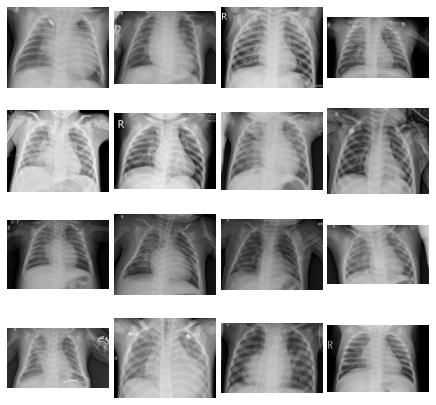

In [29]:
show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

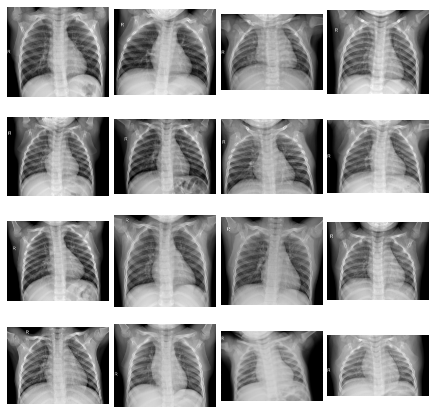

In [30]:
show_images(train_dir, label="NORMAL", size=4)

### Average image

In [32]:
#@title
def img_to_array(dir, label, size = (128,128)): #convert image to array to get mean pixel values
  image_array_list = []
  files = os.listdir(os.path.join(dir, label))
  for f in files: 
    file_path = os.path.join(os.path.join(dir, label), f)
    img = image.load_img(file_path, target_size = size, color_mode='grayscale')
    img_array = asarray(img).flatten()
    image_array_list.append(img_array)
  return image_array_list

p_imgs = img_to_array(train_dir, "PNEUMONIA")
n_imgs = img_to_array(train_dir, "NORMAL")

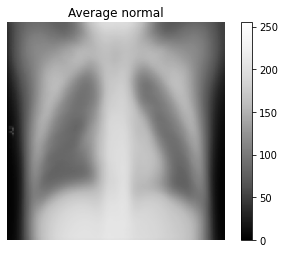

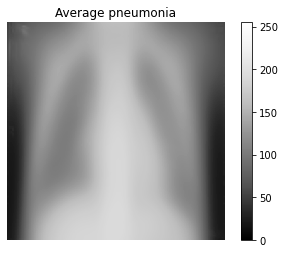

In [35]:
#@title
def average_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.mean(images_list, axis = 0)
    # reshape
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='Greys_r', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return avg_img

norm_mean = average_img(n_imgs, 'NORMAL')
pneu_mean = average_img(p_imgs, 'PNEUMONIA')
#pneumonia X-rays tend to show higher obstruction around the chest area.

###Contrast

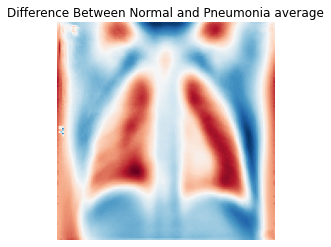

In [ ]:
#@title
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='RdBu')
plt.title(f'Difference Between Normal and Pneumonia average')
plt.axis('off')
plt.show()
#red indicates the most different areas in dark color 
#blue indicates the most different areas in light color 

### Standard deviation 

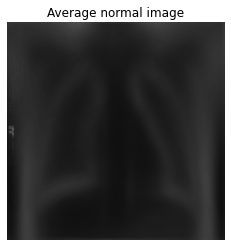

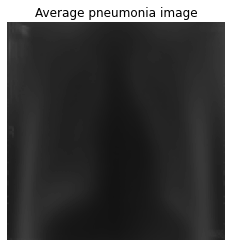

In [ ]:
#@title
def std_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.std(images_list, axis = 0)
    # reshape it back to a matrix
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='gray', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()} image')
    plt.axis('off')
    plt.show()
    return avg_img

norm_std = std_img(n_imgs, 'NORMAL')
pneu_std = std_img(p_imgs, 'PNEUMONIA')

#there are larger areas of variance found in pneumonia lung 